## ***0. Imports***

Follow alphabetical Orders for the Imports

In [205]:
from collections import Counter
from google.colab import drive
import graphviz
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from pyspark.sql import functions as fn,SparkSession
from pyspark.sql.window import *
import scipy
from scipy.stats import chi2_contingency
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve, auc,confusion_matrix,precision_score,recall_score,f1_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tabulate import tabulate
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [206]:
path_data  = '/content/drive/MyDrive/axa/depression_data.csv'

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
df_axa  =pd.read_csv(path_data)
df_spark = spark.read.csv(path_data, header=True)

## ***1. EDA***

### 1.1 Remove the Duplicates

In [207]:
df_axa.drop_duplicates(inplace =True)

### 1.2 Check for Nulls

In [208]:
# there are No null's
df_axa[df_axa.isnull().any(axis=1)]
df_axa.isnull().all(axis=1).any()

False

### 1.3 Remove the Name feature

In [209]:
# Set Visualise = True to check How many Categories of names exist
visualise = False
# Ignore and remove the Name feature - as its highly categorical
if visualise:
  df_spark.groupby(
      'Name'
  ).count().orderBy(fn.desc('count')).show()

In [210]:
if visualise:
  df_spark.filter(
      fn.col('Name') == 'Michael Smith'
  ).show()

In [211]:
df_axa[['First Name', 'Last Name']] = df_axa['Name'].str.split(' ', n=1, expand=True)
df_axa.drop(['First Name', 'Last Name'], axis=1, inplace=True)

### 1.4 Distribution of Predictions

In [212]:
predictions = df_axa['History of Mental Illness']

In [213]:
predictions.value_counts()

,count
History of Mental Illness,
No,287943
Yes,125825


Number of Mental Illnes  125825 , ( 30.409553179559563 %)
Number of Non Mental Illness  287943 , ( 69.59044682044045 %)


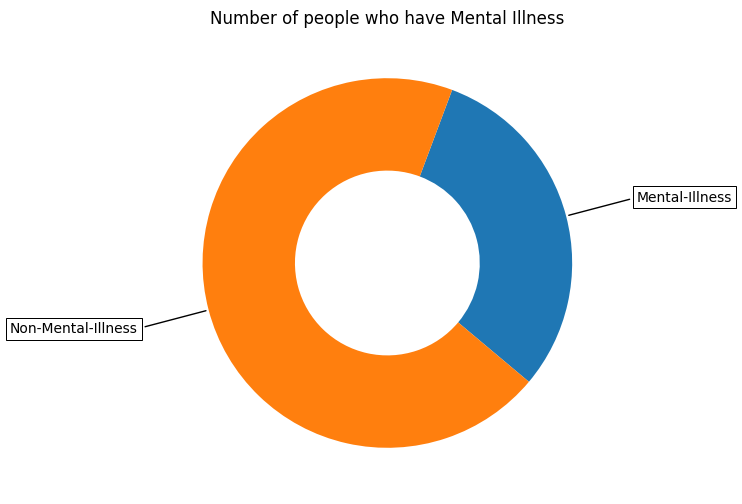

In [214]:
# PROVIDE CITATIONS TO YOUR CODE IF YOU TAKE IT FROM ANOTHER WEBSITE.
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

y_value_counts = df_axa['History of Mental Illness'].value_counts()
print("Number of Mental Illnes ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of Non Mental Illness ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Mental-Illness", "Non-Mental-Illness"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Number of people who have Mental Illness")

plt.show()

### 1.5 Removal of Columns which have Constants

In [215]:
columns_df = list(df_axa.columns)
remove_columns = []
for i in range(len(columns_df)):
  if (len(df_axa[columns_df[i]].value_counts())) == 1 :
    remove_columns.append(columns_df[i])

df_axa.drop(remove_columns,axis=1,inplace=True)
df_axa.shape
print('number of columns dropped are {}'.format(len(remove_columns)))

number of columns dropped are 0


## ***2. Numerical Distributions***

#### 2.0 - Check Distribution of Features

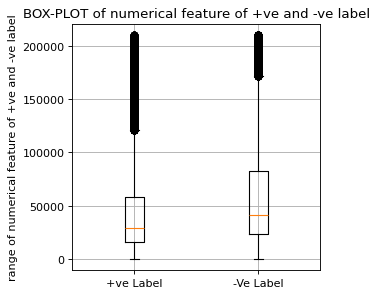

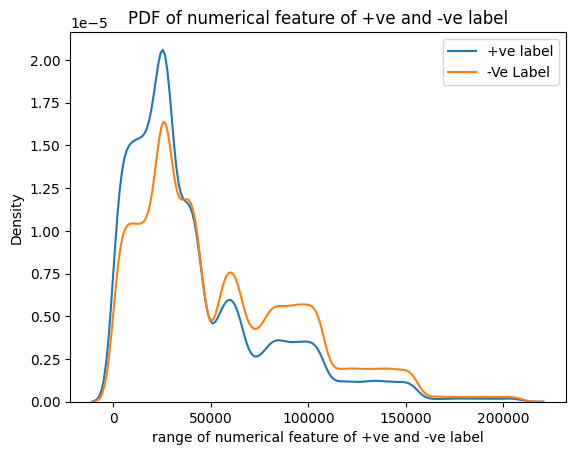

In [216]:
def plot_numerical_feature(X,feature):
  feature_numerical = np.array(list(X[X['History of Mental Illness']=='Yes'][feature]))
  no_feature_numerical = np.array(list(X[X['History of Mental Illness']=='No'][feature]))

  figure(figsize=(4, 4), dpi=80)
  plt.figure(1)
  plt.boxplot([feature_numerical, no_feature_numerical])
  plt.title('BOX-PLOT of numerical feature of +ve and -ve label')
  plt.xticks([1,2],('+ve Label','-Ve Label'))
  plt.ylabel('range of numerical feature of +ve and -ve label')
  plt.grid()

  plt.figure(2)
  sns.distplot(feature_numerical, hist=False, label="+ve label")
  sns.distplot(no_feature_numerical, hist=False, label="-Ve Label")
  plt.title('PDF of numerical feature of +ve and -ve label')
  plt.xlabel('range of numerical feature of +ve and -ve label')
  plt.legend()
  plt.show()

# check the box-plot and PDf curve of any numerical-feature
column_name = 'Income'
plot_numerical_feature(df_axa,df_axa.columns[columns_df.index(column_name)])

In [217]:
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

# test_box_plot = False
# if test_box_plot:
#   labels = ['data1']
#   column_name = 'Income'
#   data1 = list(df_axa[df_axa['History of Mental Illness']=='Yes'][column_name])
#   data1 = np.array(data1)
#   bp = plt.boxplot([data1], labels=labels)
#   print(get_box_plot_data(labels, bp))
#   plt.show()

### 2.1 - Clip the Numerical Distributions

In [218]:
df_yes = df_axa[df_axa['History of Mental Illness'] == 'Yes']
df_no = df_axa[df_axa['History of Mental Illness'] == 'No']

def clip_values(df, column_name, label):
  income_category = []
  labels = [label]
  data1 = list(df[df['History of Mental Illness']==label][column_name])
  data1 = np.array(data1)
  bp = plt.boxplot([data1], labels=labels)
  threshold = get_box_plot_data(labels, bp)['upper_whisker'][0]
  output = np.clip([data1], 0, threshold)[0]
  print(sum(i > threshold for i in data1) /len(data1) * 100, '%number of points being clipped')
  return output

1.0679196924391285 %number of points being clipped


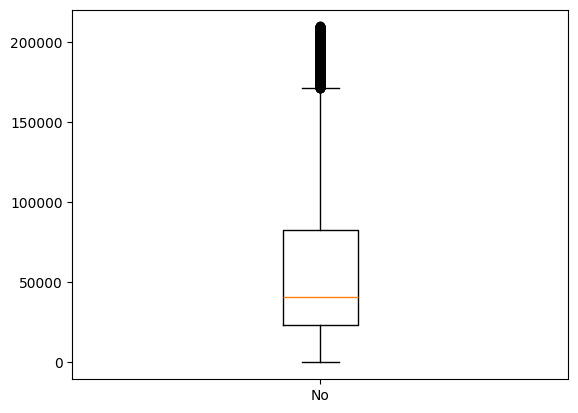

In [219]:
df_no['income_clipped'] = clip_values(df_no, 'Income','No')

5.039539042320683 %number of points being clipped


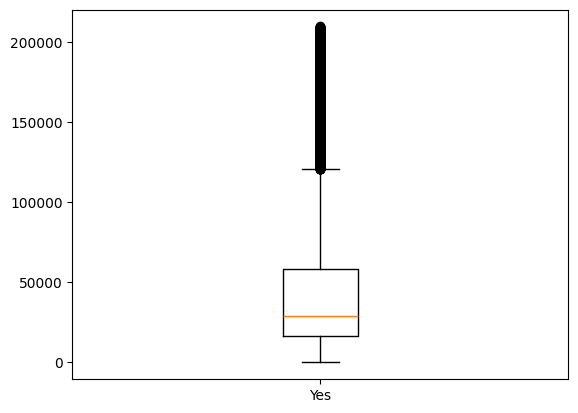

In [220]:
df_yes['income_clipped'] = clip_values(df_yes, 'Income','Yes')

### 2.2 - Create a Income-Category

In [221]:
result = pd.concat([df_no, df_yes])
predictions  = result['History of Mental Illness']
result['income_category'] = pd.qcut(result['income_clipped'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

In [222]:
display(result)

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions,income_clipped,income_category
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No,125332.79,Very High
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No,9992.78,Low
5,Kathy Hill,20,Single,High School,0,Former,Active,Employed,44448.91,Low,Unhealthy,Fair,No,Yes,No,No,44448.91,High
6,Crystal Delgado,60,Widowed,Associate Degree,1,Non-smoker,Sedentary,Unemployed,22565.47,Moderate,Moderate,Poor,No,Yes,No,No,22565.47,Medium
7,Charles Kaiser,31,Single,High School,0,Non-smoker,Active,Employed,39608.18,Moderate,Unhealthy,Good,No,No,No,No,39608.18,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413751,Cynthia Murphy,34,Married,Master's Degree,1,Former,Moderate,Employed,93069.08,Low,Moderate,Poor,Yes,No,No,No,93069.08,Very High
413756,Karl Elliott,72,Married,High School,3,Non-smoker,Sedentary,Employed,35031.68,Low,Unhealthy,Poor,Yes,No,No,No,35031.68,Medium
413760,Sophia Allen,46,Married,High School,1,Non-smoker,Sedentary,Employed,26153.32,Low,Unhealthy,Poor,Yes,No,No,Yes,26153.32,Medium
413762,Janice Robertson,28,Single,Bachelor's Degree,0,Non-smoker,Active,Unemployed,5971.27,Moderate,Moderate,Fair,Yes,Yes,No,No,5971.27,Low


### 2.3 Create a new Age feature

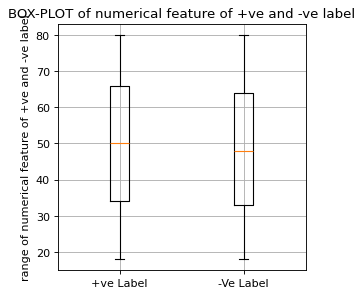

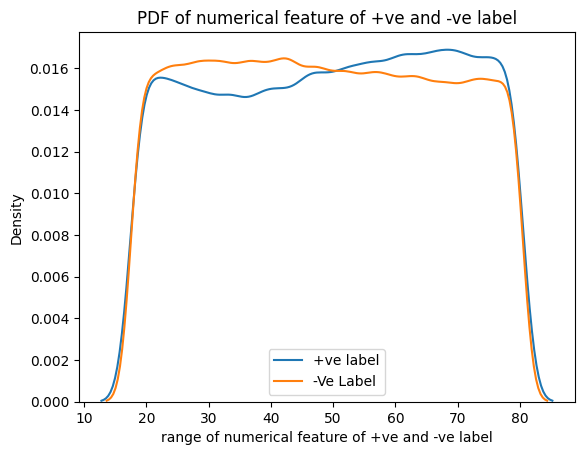

In [223]:
# check the box-plot and PDf curve of any numerical-feature
column_name = 'Age'
plot_numerical_feature(result,result.columns[columns_df.index(column_name)])

#### 2.3.1 Bin the Age into certain Categories

In [224]:
bins = np.array([16,22,30,40,50,60,70,80])
bins_age = pd.cut(result.Age,bins).value_counts()
result['age_boundary'] = [str(i.left)+ '-'+str(i.right) for i in list(pd.cut(result.Age,bins))]
print(bins_age,set(list(result['age_boundary'])))

Age
(40, 50]    66017
(50, 60]    65888
(60, 70]    65656
(30, 40]    65505
(70, 80]    65451
(22, 30]    52711
(16, 22]    32540
Name: count, dtype: int64 {'30-40', '70-80', '40-50', '16-22', '22-30', '60-70', '50-60'}


#### 2.3.2 Create a new Age Category

In [225]:
result['age_c'] = result['age_boundary'].apply(
	lambda  x: 6 if (x == '16-22') else (
			 5 if x == "22-30" else (
						4 if x == '30-40' else (
								 3 if x == "40-50" else (
											2 if x == "50-60" else (
								 1 if x == "60-70" else 0))))))

## ***3. Categorical Variables***

### 3.1-generate Nominal features from Categorical Features

In [226]:
# you can always use simple mapping on binary features.
result['substance_c'] = result['History of Substance Abuse'].apply(
	lambda x: 1 if x == 'Yes' else 0)

result['depression_c'] = result['Family History of Depression'].apply(
	lambda x: 1 if x == 'Yes' else 0)

result['medical_c'] = result['Chronic Medical Conditions'].apply(
	lambda x: 1 if x == 'Yes' else 0)

result['employement_c'] = result['Employment Status'].apply(
	lambda x: 1 if x == 'Unemployed' else 0)

result['alcohol_c'] = result['Alcohol Consumption'].apply(
	lambda x: 2 if x == 'High' else (0 if x == 'Low' else 1))

result['sleep_c'] = result['Sleep Patterns'].apply(
	lambda x: 2 if x == 'Poor' else (0 if x == 'Fair' else 1))

result['dietary_c'] = result['Dietary Habits'].apply(
	lambda x: 2 if x == 'Unhealthy' else (0 if x == 'Healthy' else 1))

result['physical_c'] = result['Physical Activity Level'].apply(
	lambda x: 2 if x == 'Sedentary' else (0 if x == 'Active' else 1))

result['smoker_c'] = result['Smoking Status'].apply(
	lambda x: 2 if x == 'Current' else (0 if x == 'Non-smoker' else 1))

result['marital_c'] = result['Marital Status'].apply(
	lambda x: 2 if (x == 'Divorced') or (x == 'Widowed')  else (0 if x == 'Married' else 1))

result['income_c'] = result['income_category'].apply(
	lambda x: 3 if (x == 'Very High') else (2 if x == 'High' else (1 if x == 'Medium' else 1)))

result['education_c'] = result['Education Level'].apply(
	lambda x: 4 if (x == 'High School') else (3 if x == "Bachelor's Degree" else (2 if x == 'Associate Degree' else (0 if x == "Master's Degree" else 1))))

In [228]:
result.columns

Index(['Name', 'Age', 'Marital Status', 'Education Level',
       'Number of Children', 'Smoking Status', 'Physical Activity Level',
       'Employment Status', 'Income', 'Alcohol Consumption', 'Dietary Habits',
       'Sleep Patterns', 'History of Mental Illness',
       'History of Substance Abuse', 'Family History of Depression',
       'Chronic Medical Conditions', 'income_clipped', 'income_category',
       'age_boundary', 'age_c', 'substance_c', 'depression_c', 'medical_c',
       'employement_c', 'alcohol_c', 'sleep_c', 'dietary_c', 'physical_c',
       'smoker_c', 'marital_c', 'income_c', 'education_c'],
      dtype='object')

## ***4. Tests***

### 4.0 Visualize the Features

<Axes: xlabel='employement_c', ylabel='Count'>

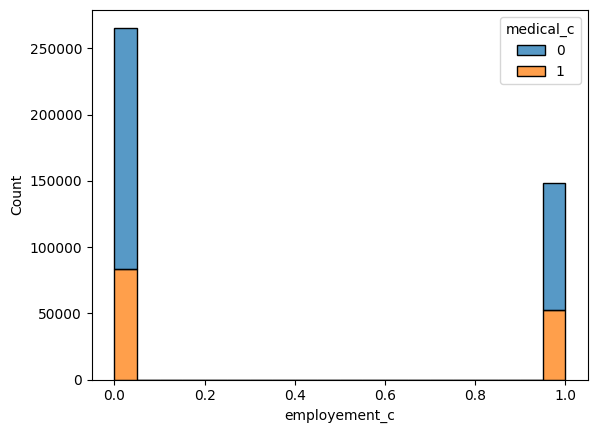

In [229]:
sns.histplot(binwidth=0.05, x="employement_c", hue="medical_c", data=result, stat="count", multiple="stack")

<Axes: xlabel='employement_c', ylabel='Count'>

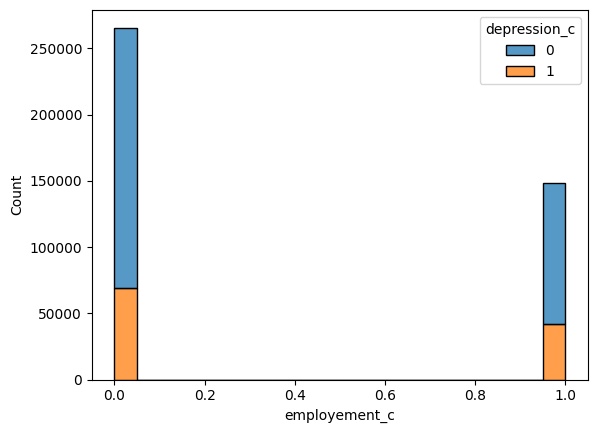

In [230]:
sns.histplot(binwidth=0.05, x="employement_c", hue="depression_c", data=result, stat="count", multiple="stack")

### 4.1 Chi2 Test

In [231]:
def chi2_test(data, features):
  dependent_features = []
  for i in range(len(features)):
    for j in range(i+1, len(features)):
      chisqt = pd.crosstab(data[features[i]], data[features[j]], margins=True)
      chi2, p, dof, expected = chi2_contingency(chisqt)

      if p <= 0.05:
          print(features[i],features[j] , 'these two features are dependent')
          dependent_features.append([features[i],features[j]])
  return dependent_features

#### 4.1.1 Remove Dependent features from Chi2Test

we Check this only for Degree's of two

In [232]:
for i in chi2_test(result, ['substance_c','depression_c', 'medical_c', 'employement_c']):
  a = i[0]+ '-' +i[1]
  result[a] = result[i[0]].astype(str) + result[i[1]].astype(str)
result.drop('employement_c',inplace=True, axis =1)

depression_c employement_c these two features are dependent
medical_c employement_c these two features are dependent


In [233]:
print(chi2_test(result, ['depression_c-employement_c','depression_c']),
      chi2_test(result, ['depression_c-employement_c','medical_c']),
      chi2_test(result, ['medical_c-employement_c','medical_c']),
      chi2_test(result, ['medical_c-employement_c','depression_c']))

depression_c-employement_c depression_c these two features are dependent
depression_c-employement_c medical_c these two features are dependent
medical_c-employement_c medical_c these two features are dependent
medical_c-employement_c depression_c these two features are dependent
[['depression_c-employement_c', 'depression_c']] [['depression_c-employement_c', 'medical_c']] [['medical_c-employement_c', 'medical_c']] [['medical_c-employement_c', 'depression_c']]


In [234]:
result[['depression_c-employement_c','medical_c-employement_c']]

,depression_c-employement_c,medical_c-employement_c
2,10,00
3,01,01
5,00,00
6,01,01
7,00,00
...,...,...
413751,00,00
413756,00,00
413760,00,10
413762,01,01


### 4.2 VIF Factor

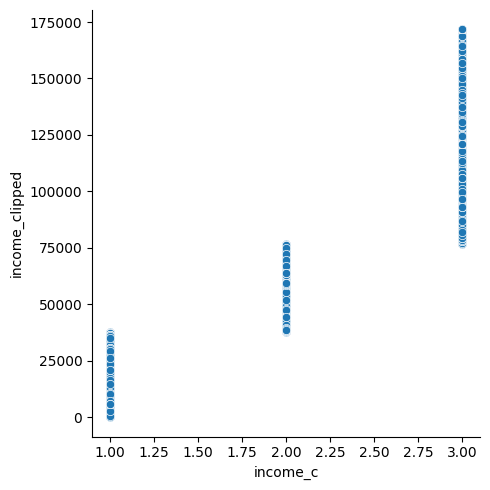

In [237]:
sns.relplot(
    data=result, x="income_c", y="income_clipped",
)

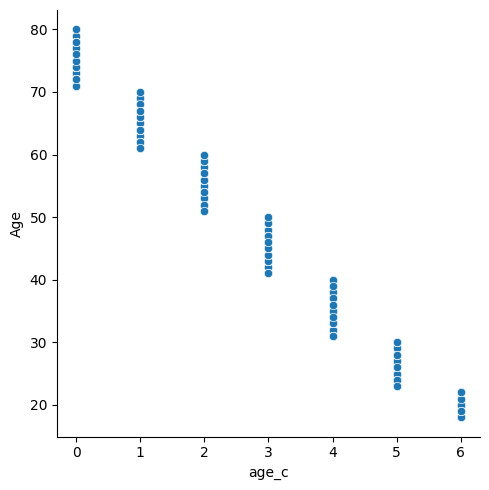

In [238]:
sns.relplot(
    data=result, x="age_c", y="Age"
)

In [239]:
numerical_features = [
    'Age', 'Number of Children', 'income_clipped'
] + ['substance_c',
       'depression_c', 'medical_c', 'alcohol_c', 'sleep_c', 'dietary_c',
       'physical_c', 'smoker_c', 'marital_c', 'income_c', 'education_c',
       'age_c']

def calculate_gvif(X):
    gvif = np.array([variance_inflation_factor(X.values, i) for i in range(X.shape[1])])
    gvif_df = pd.DataFrame({'Variable': X.columns, 'GVIF': gvif})
    return gvif_df

vif_df = result[numerical_features]
# Calculate initial GVIF
gvif_df = calculate_gvif(vif_df)

# Loop to remove columns with GVIF > 5
while gvif_df['GVIF'].max() > 5:
    # Find the column with the highest GVIF
    max_vif_col = gvif_df.loc[gvif_df['GVIF'].idxmax(), 'Variable']

    # Remove the column with the highest GVIF
    vif_df = vif_df.drop(max_vif_col, axis=1)
    print('Dropping Feature',max_vif_col)
    # Recalculate GVIF
    gvif_df = calculate_gvif(vif_df)

# Final GVIF results
print("Final GVIF after removing high VIF columns:")
print(gvif_df)
print(vif_df.columns)

Dropping Feature income_c
Dropping Feature Age
Final GVIF after removing high VIF columns:
              Variable      GVIF
0   Number of Children  2.154783
1       income_clipped  2.598112
2          substance_c  1.433746
3         depression_c  1.409345
4            medical_c  1.457495
5            alcohol_c  2.363473
6              sleep_c  1.883391
7            dietary_c  4.432449
8           physical_c  4.389059
9             smoker_c  1.723442
10           marital_c  1.628488
11         education_c  4.078322
12               age_c  3.623191
Index(['Number of Children', 'income_clipped', 'substance_c', 'depression_c',
       'medical_c', 'alcohol_c', 'sleep_c', 'dietary_c', 'physical_c',
       'smoker_c', 'marital_c', 'education_c', 'age_c'],
      dtype='object')


### 4.3 Corelation Matrix of Numerical Features

In [240]:
def remove_multicollinearity(X,threshold):
  corr_matrix = X.corr().abs()

  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

  # Find features with correlation greater than threshold
  to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

  # Drop features
  X_not_collinear = X.drop(to_drop, axis=1)
  print('removing these collinear Columns {}'.format(to_drop))
  return X_not_collinear,to_drop

# change the Threshold to check the How much Data are we loosing
df_notcollinear,dropped_columns = remove_multicollinearity(vif_df,0.90)
# check the No.of.features before and after checking Multicollinearity
df_notcollinear.shape,vif_df.shape

removing these collinear Columns []


((413768, 13), (413768, 13))

In [241]:
df_notcollinear.columns,

(Index(['Number of Children', 'income_clipped', 'substance_c', 'depression_c',
        'medical_c', 'alcohol_c', 'sleep_c', 'dietary_c', 'physical_c',
        'smoker_c', 'marital_c', 'education_c', 'age_c'],
       dtype='object'),)

##  ***5. Add a Probability feature to categorical featrues- Not needed***

In [39]:
df_notcollinear['label'] = predictions
df_spark = spark.createDataFrame(df_notcollinear)

df_out = df_spark.withColumn(
    'substance_total',
    fn.count(fn.col('substance_c')).over(Window.partitionBy('substance_c'))
).withColumn(
    'substance_pr',
    fn.count(fn.col('substance_c')).over(Window.partitionBy('substance_c','label'))
).select(
    'substance_total',
    'substance_pr',
    'substance_c',
    'label',
    fn.col('substance_pr')/fn.col('substance_total')
).distinct()

In [40]:
df_notcollinear.columns

Index(['Number of Children', 'income_clipped', 'substance_c', 'depression_c',
       'medical_c', 'alcohol_c', 'sleep_c', 'dietary_c', 'physical_c',
       'smoker_c', 'marital_c', 'education_c', 'age_c', 'label'],
      dtype='object')

In [41]:
list_columns_pr = ['substance_c', 'depression_c',
       'medical_c', 'alcohol_c', 'sleep_c', 'dietary_c', 'physical_c',
       'smoker_c', 'marital_c', 'education_c', 'age_c',]

In [42]:
additional_columns = []
for i in list_columns_pr:
  additional_columns.append(i + str('_p'))
  df_spark = df_spark.withColumn(
      (i + str('_p')),
      (fn.count(fn.col(i)).over(Window.partitionBy(i,'label'))) /
      (fn.count(fn.col(i)).over(Window.partitionBy(i)))
  )

df_spark.withColumn(
      'any', fn.aggregate(fn.array(*additional_columns), fn.lit(False), lambda acc, x: acc | ( (x <= 0.15) | (x >=0.80)))
  ).filter(fn.col('any') == True).show()

+------------------+--------------+-----------+------------+---------+---------+-------+---------+----------+--------+---------+-----------+-----+-----+-------------+--------------+-----------+-----------+---------+-----------+------------+----------+-----------+-------------+-------+---+
|Number of Children|income_clipped|substance_c|depression_c|medical_c|alcohol_c|sleep_c|dietary_c|physical_c|smoker_c|marital_c|education_c|age_c|label|substance_c_p|depression_c_p|medical_c_p|alcohol_c_p|sleep_c_p|dietary_c_p|physical_c_p|smoker_c_p|marital_c_p|education_c_p|age_c_p|any|
+------------------+--------------+-----------+------------+---------+---------+-------+---------+----------+--------+---------+-----------+-----+-----+-------------+--------------+-----------+-----------+---------+-----------+------------+----------+-----------+-------------+-------+---+
+------------------+--------------+-----------+------------+---------+---------+-------+---------+----------+--------+---------+--

In [43]:
df_spark.limit(10).show()

+------------------+--------------+-----------+------------+---------+---------+-------+---------+----------+--------+---------+-----------+-----+-----+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|Number of Children|income_clipped|substance_c|depression_c|medical_c|alcohol_c|sleep_c|dietary_c|physical_c|smoker_c|marital_c|education_c|age_c|label|     substance_c_p|    depression_c_p|       medical_c_p|       alcohol_c_p|         sleep_c_p|      dietary_c_p|     physical_c_p|        smoker_c_p|       marital_c_p|     education_c_p|           age_c_p|
+------------------+--------------+-----------+------------+---------+---------+-------+---------+----------+--------+---------+-----------+-----+-----+------------------+------------------+------------------+------------------+------------------+-----------------+---------------

## ***6. Modelling***

### 6.0 Utility Functions

In [242]:
def calculate_metrics(y_true, y_pred):

  fpr,tpr,thresholds = roc_curve(y_true,y_pred)
  auc_score = auc(fpr, tpr)
  threshold_constant = thresholds[np.argmax(tpr*(1-fpr))]
  predictions = [1 if i>=threshold_constant else 0 for i in y_pred]

  accuracy = accuracy_score(y_true, predictions)
  precision= precision_score(y_true, predictions)
  recall = recall_score(y_true, predictions)
  f1 = f1_score(y_true, predictions)

  TN,FP,FN,TP = confusion_matrix(y_true,predictions).ravel() # Use 'predictions' here

  accuracy_positive = TP/(TP+FN)
  accuracy_negative = TN/(TN+FP)

  return accuracy,auc_score,precision,recall,f1,accuracy_positive,accuracy_negative

In [243]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):

    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(5,5))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".1f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(5,5))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".1f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(5,5))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".1f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [244]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### 6.1 Divide into Train, test, Split

In [247]:
df_notcollinear['label'] = predictions
df_notcollinear['label_c'] = df_notcollinear['label'].apply(
	lambda x: 1 if x == 'Yes' else 0)

y  = df_notcollinear['label_c']
dataset = df_notcollinear.drop(['label_c','label'],axis=1)

df_notcollinear.to_pickle('/content/drive/MyDrive/axa/processed_data.pkl')
column_names = dataset.columns

In [248]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=0.3,random_state=0,stratify=y)
feature_names = X_train.columns

X_train_cn = scipy.sparse.csr_matrix(X_train)
X_test_cn = scipy.sparse.csr_matrix(X_test)
# # split the train data set into cross validation train and cross validation test
# X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3,random_state=0,stratify=y_1)

### 6.2 Train a Random Forest Model

In [96]:
train_auc = []
test_auc = []

estimator_values = [5, 10, 50,100]
depth_values = [2, 5, 10,20,40]

for j in tqdm(estimator_values):
  for i in depth_values:
      model_rf = RandomForestClassifier(n_estimators=j, max_depth=i,class_weight="balanced")
      model_rf.fit(X_train_cn, y_train)
      y_train_pred = []
      for k in range(0,X_train_cn.shape[0],100):
          y_train_pred.extend(model_rf.predict_proba(X_train_cn[k:k+100])[:,1])

      y_test_pred = []
      for k in range(0, X_test_cn.shape[0],100):
          y_test_pred.extend(model_rf.predict_proba(X_test_cn[k:k+100])[:,1])
      train_auc.append(roc_auc_score(y_train,y_train_pred))
      test_auc.append(roc_auc_score(y_test, y_test_pred))

100%|██████████| 4/4 [20:37<00:00, 309.30s/it]


#### 6.2.1 Visualise the Grid Search Loss

<Axes: >

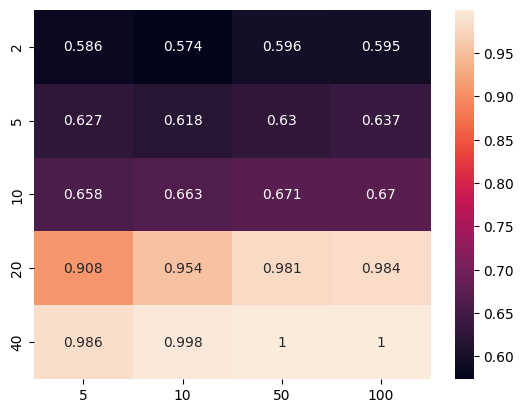

In [98]:
df_train = pd.DataFrame(np.array(train_auc).reshape(len(estimator_values),len(depth_values)).T,
                        columns=estimator_values,index = depth_values)
sns.heatmap(df_train,annot=True,fmt='.3g')

<Axes: >

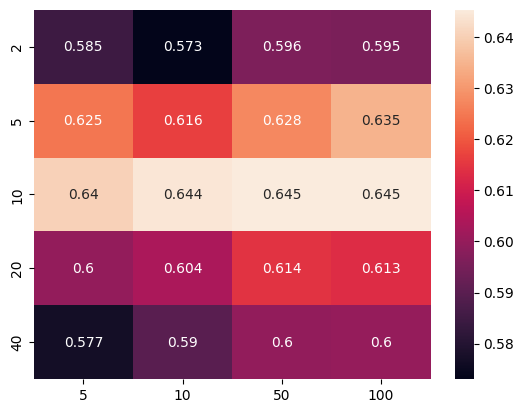

In [99]:
df_test = pd.DataFrame(np.array(test_auc).reshape(len(estimator_values),len(depth_values)).T,
                       columns=estimator_values,index = depth_values)
sns.heatmap(df_test,annot=True,fmt='.3g')

#### 6.2.2 Choose the Best Model from grid Search

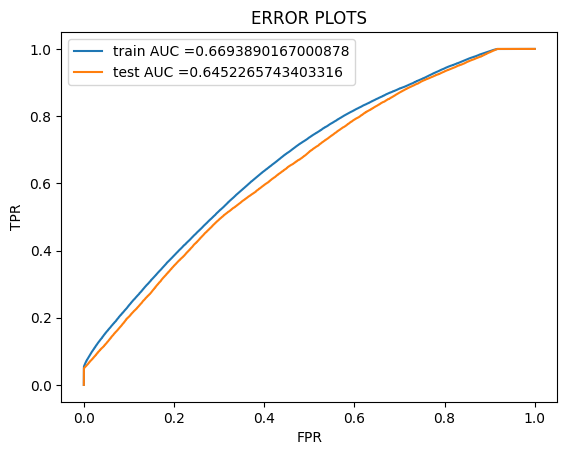

In [249]:
rf_best = RandomForestClassifier(n_estimators=50, max_depth=10,class_weight="balanced")
rf_best.fit(X_train_cn, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = []
for k in range(0,X_train_cn.shape[0],1000):
  y_train_pred.extend(rf_best.predict_proba(X_train_cn[k:k+1000])[:,1])
y_test_pred = []
for k in range(0, X_test_cn.shape[0],1000):
  y_test_pred.extend(rf_best.predict_proba(X_test_cn[k:k+1000])[:,1])

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train,y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()
print("="*100)

#### 6.2.3 Confusion matrices, Precision matrix, Recall matrix

train Confusion Matrix
the maximum value of tpr*(1-fpr) 0.38230722590932886 for threshold 0.507
Number of misclassified points  38.70499970652921
-------------------- Confusion matrix --------------------


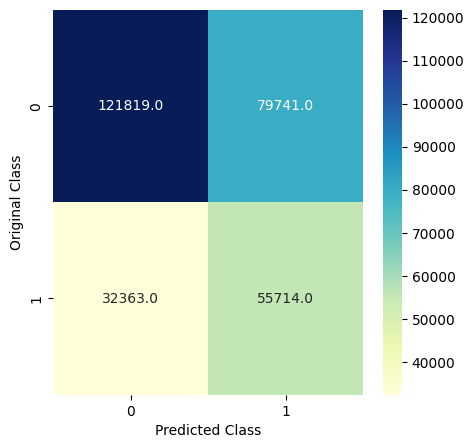

-------------------- Precision matrix (Columm Sum=1) --------------------


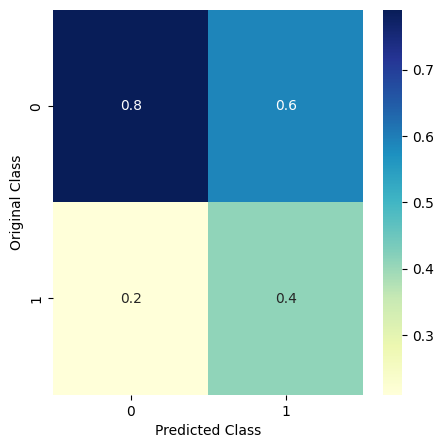

-------------------- Recall matrix (Row sum=1) --------------------


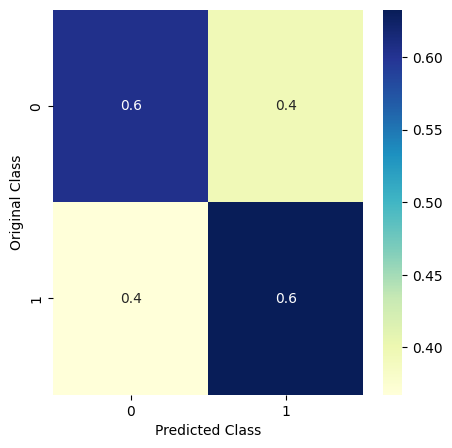

In [250]:
print("train Confusion Matrix")
plot_confusion_matrix(y_train,predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.3571359525838714 for threshold 0.508
Number of misclassified points  40.18335468174751
-------------------- Confusion matrix --------------------


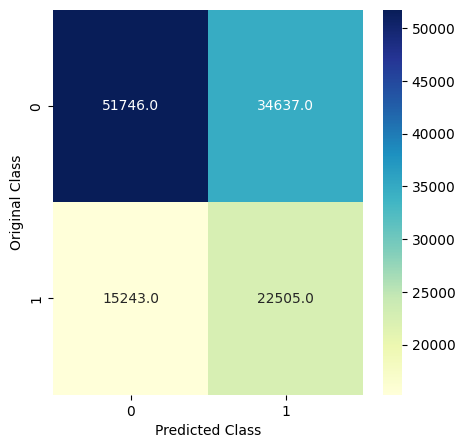

-------------------- Precision matrix (Columm Sum=1) --------------------


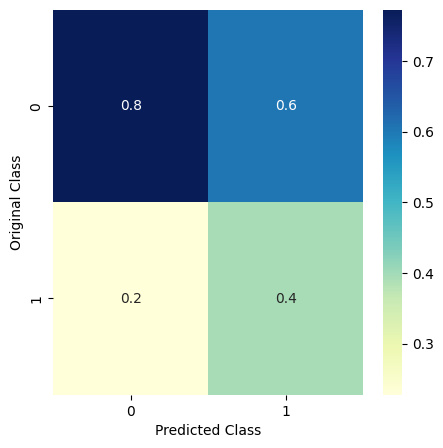

-------------------- Recall matrix (Row sum=1) --------------------


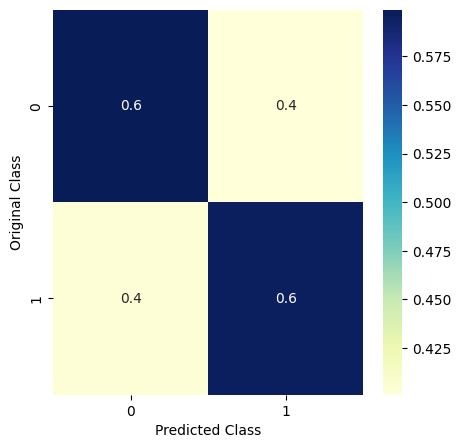

In [251]:
print("Test confusion matrix")
plot_confusion_matrix(y_test, predict( y_test_pred, te_thresholds, test_fpr, test_tpr))

#### 6.2.4 Feature Importance

In [252]:
importances = rf_best.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Impurity': importances}).sort_values('Gini Impurity', ascending=False)
print(feature_imp_df)

               Feature  Gini Impurity
1       income_clipped       0.835063
11         education_c       0.046938
6              sleep_c       0.019689
12               age_c       0.017883
9             smoker_c       0.013875
10           marital_c       0.012689
7            dietary_c       0.011756
0   Number of Children       0.011212
5            alcohol_c       0.008617
8           physical_c       0.007543
2          substance_c       0.005202
4            medical_c       0.004962
3         depression_c       0.004572


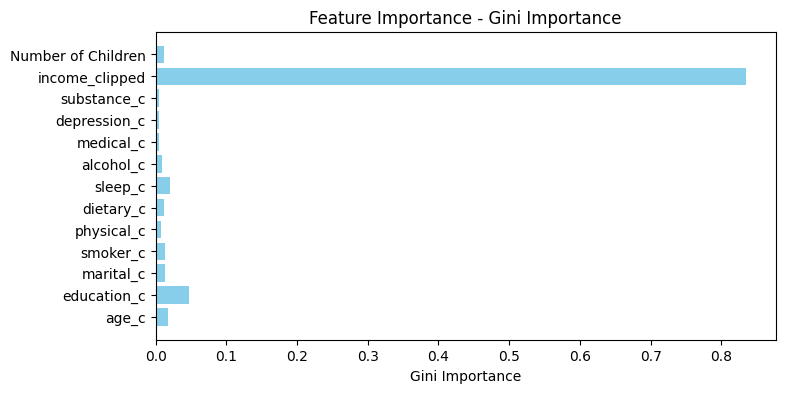

In [253]:
# Create a bar plot for feature importance
plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

#### 6.2.5 Add Random Forest Metrics to Metrics Table

In [254]:
df_metrics = pd.DataFrame(columns=
      ['model','data','accuracy','auc','precision','recall','f1_score','accuracy_positive','accuracy_negative']
                          )
df_metrics['model'] = 'Random Forest'
metrics = list(calculate_metrics(y_test,y_test_pred))
metrics.insert(0,'Random Forest')
metrics.insert(1,'test')
df_metrics.loc[len(df_metrics)] = metrics

metrics = list(calculate_metrics(y_train, y_train_pred))
metrics.insert(0,'Random Forest')
metrics.insert(1,'train')
df_metrics.loc[len(df_metrics)] = metrics

In [255]:
display(df_metrics)

,model,data,accuracy,auc,precision,recall,f1_score,accuracy_positive,accuracy_negative
0,Random Forest,test,0.598166,0.645227,0.393843,0.596191,0.474339,0.596191,0.599030
1,Random Forest,train,0.612950,0.669389,0.411310,0.632560,0.498488,0.632560,0.604381


#### 6.2.6 Biases of Random Forest

In [256]:
X_train['label'] = y_train
X_train['prediction'] = predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)

wrong_predictions = X_train[X_train['label'] != X_train['prediction']]
right_predictions = X_train[X_train['label'] == X_train['prediction']]

the maximum value of tpr*(1-fpr) 0.38230722590932886 for threshold 0.507


##### 6.2.6.1 Distribution Bias of Income

Distribution of Income feature for predicted Labels


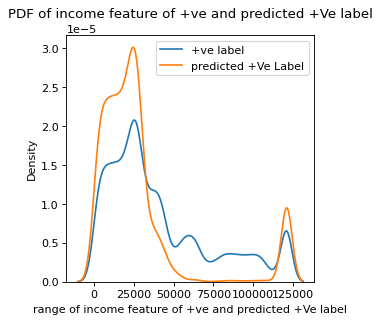

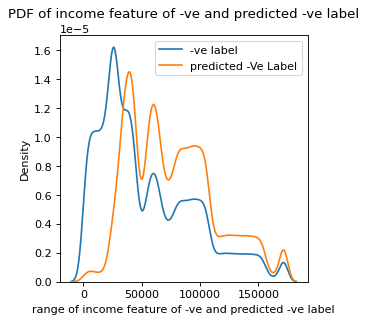

In [272]:
# check the box-plot and PDf curve of any numerical-feature
column_name = 'income_clipped'
columns_df = list(X_train.columns)
# plot_numerical_feature(wrong_predictions,wrong_predictions.columns[columns_df.index(column_name)])

def plot_numerical_feature(X,feature):
  feature_numerical = np.array(list(X[X['label']==1][feature]))
  no_feature_numerical = np.array(list(X[(X['prediction']==1) & (X['label']==1)][feature]))
  figure(figsize=(4, 4), dpi=80)

  plt.figure(1)
  sns.distplot(feature_numerical, hist=False, label="+ve label")
  sns.distplot(no_feature_numerical, hist=False, label="predicted +Ve Label")
  plt.title('PDF of income feature of +ve and predicted +Ve label')
  plt.xlabel('range of income feature of +ve and predicted +Ve label')
  plt.legend()

  feature_numerical = np.array(list(X[X['label']==0][feature]))
  no_feature_numerical = np.array(list(X[(X['prediction']==0) & (X['label']==0)][feature]))

  figure(figsize=(4, 4), dpi=80)

  plt.figure(2)
  sns.distplot(feature_numerical, hist=False, label="-ve label")
  sns.distplot(no_feature_numerical, hist=False, label="predicted -Ve Label")
  plt.title('PDF of income feature of -ve and predicted -ve label')
  plt.xlabel('range of income feature of -ve and predicted -ve label')
  plt.legend()
  plt.show()

print('Distribution of Income feature for predicted Labels')
plot_numerical_feature(X_train,column_name)

##### 6.2.6.2 Categorical-Selection Bias of Smoker

In [273]:
df = spark.createDataFrame(X_train)
df.groupBy(
    fn.col('smoker_c'),fn.col('label')
    ).agg(
    fn.count(fn.col('prediction')).alias('total_count_in_group'),
    fn.sum(fn.col('label')).alias('total_number_of_mental_illnes'),
    fn.sum(fn.col('prediction')).alias('predicted_as_mental_illnes'),
    ((fn.sum(fn.col('prediction')) - fn.sum(fn.col('label')))*100 / fn.count(fn.col('label'))).alias(
        'percentage Correctly predicted'
    ),
    ).orderBy(fn.col('smoker_c'),fn.col('label')).show()

+--------+-----+--------------------+-----------------------------+--------------------------+------------------------------+
|smoker_c|label|total_count_in_group|total_number_of_mental_illnes|predicted_as_mental_illnes|percentage Correctly predicted|
+--------+-----+--------------------+-----------------------------+--------------------------+------------------------------+
|       0|    0|              119973|                            0|                     51956|             43.30641060905371|
|       0|    1|               53023|                        53023|                     35564|           -32.927220262904775|
|       1|    0|               56775|                            0|                     23195|             40.85424922941436|
|       1|    1|               24571|                        24571|                     15921|            -35.20410239713483|
|       2|    0|               24812|                            0|                      4590|            18.499113332

In [274]:
df_wrong = spark.createDataFrame(wrong_predictions)
df_wrong.groupBy(
    fn.col('smoker_c')
    ).agg(
    fn.count(fn.col('prediction')).alias('total_count_in_group'),
    fn.sum(fn.col('label')).alias('total_number_of_mental_illnes'),
    fn.sum(fn.col('prediction')).alias('predicted_as_mental_illnes'),
    ((fn.sum(fn.col('prediction')) - fn.sum(fn.col('label')))*100 / fn.count(fn.col('label'))).alias(
        'percentage Correctly predicted'
    ),
    ).show()

+--------+--------------------+-----------------------------+--------------------------+------------------------------+
|smoker_c|total_count_in_group|total_number_of_mental_illnes|predicted_as_mental_illnes|percentage Correctly predicted|
+--------+--------------------+-----------------------------+--------------------------+------------------------------+
|       0|               69415|                        17459|                     51956|            49.696751422603185|
|       1|               31845|                         8650|                     23195|            45.674360182132204|
|       2|               10844|                         6254|                      4590|            -15.34489118406492|
+--------+--------------------+-----------------------------+--------------------------+------------------------------+



In [275]:
df_right = spark.createDataFrame(right_predictions)
df_right.groupBy(
    fn.col('smoker_c')
    ).agg(
    fn.count(fn.col('prediction')).alias('total_count_in_group'),
    fn.sum(fn.col('label')).alias('total_number_of_mental_illnes'),
    fn.sum(fn.col('prediction')).alias('predicted_as_mental_illnes'),
    ((fn.sum(fn.col('prediction')) - fn.sum(fn.col('label')))*100 / fn.count(fn.col('label'))).alias(
        'percentage Correctly predicted'
    ),
    ).show()

+--------+--------------------+-----------------------------+--------------------------+------------------------------+
|smoker_c|total_count_in_group|total_number_of_mental_illnes|predicted_as_mental_illnes|percentage Correctly predicted|
+--------+--------------------+-----------------------------+--------------------------+------------------------------+
|       0|              103581|                        35564|                     35564|                           0.0|
|       1|               49501|                        15921|                     15921|                           0.0|
|       2|               24451|                         4229|                      4229|                           0.0|
+--------+--------------------+-----------------------------+--------------------------+------------------------------+



##### 6.2.6.3 Categorical-Selection Bias of Age

In [277]:
df_wrong.groupBy(
    fn.col('age_c')
    ).agg(
    fn.count(fn.col('prediction')).alias('total_count_in_group'),
    fn.sum(fn.col('label')).alias('total_number_of_mental_illnes'),
    fn.sum(fn.col('prediction')).alias('predicted_as_mental_illnes'),
    ((fn.sum(fn.col('prediction')) - fn.sum(fn.col('label')))*100 / fn.count(fn.col('label'))).alias(
        'percentage Correctly predicted'
    ),
    ).orderBy('age_c').show()

+-----+--------------------+-----------------------------+--------------------------+------------------------------+
|age_c|total_count_in_group|total_number_of_mental_illnes|predicted_as_mental_illnes|percentage Correctly predicted|
+-----+--------------------+-----------------------------+--------------------------+------------------------------+
|    0|               20157|                         3257|                     16900|             67.68368308776108|
|    1|               20189|                         3609|                     16580|              64.2478577443162|
|    2|               18753|                         4206|                     14547|            55.143177091665336|
|    3|               16370|                         5776|                     10594|             29.43188759926695|
|    4|               14661|                         6646|                      8015|             9.337698656299025|
|    5|               12608|                         5823|      

In [278]:
df_right.groupBy(
    fn.col('age_c')
    ).agg(
    fn.count(fn.col('prediction')).alias('total_count_in_group'),
    fn.sum(fn.col('label')).alias('total_number_of_mental_illnes'),
    fn.sum(fn.col('prediction')).alias('predicted_as_mental_illnes'),
    ((fn.sum(fn.col('prediction')) - fn.sum(fn.col('label')))*100 / fn.count(fn.col('label'))).alias(
        'percentage Correctly predicted'
    ),
    ).orderBy('age_c').show()

+-----+--------------------+-----------------------------+--------------------------+------------------------------+
|age_c|total_count_in_group|total_number_of_mental_illnes|predicted_as_mental_illnes|percentage Correctly predicted|
+-----+--------------------+-----------------------------+--------------------------+------------------------------+
|    0|               25506|                        11387|                     11387|                           0.0|
|    1|               25784|                        11145|                     11145|                           0.0|
|    2|               27379|                        10062|                     10062|                           0.0|
|    3|               29743|                         7800|                      7800|                           0.0|
|    4|               31275|                         6348|                      6348|                           0.0|
|    5|               24277|                         4901|      

##### 6.2.6.4 Categorical-Selection Bias of Education

In [279]:
df_wrong.groupBy(
    fn.col('education_c')
    ).agg(
    fn.count(fn.col('prediction')).alias('total_count_in_group'),
    fn.sum(fn.col('label')).alias('total_number_of_mental_illnes'),
    fn.sum(fn.col('prediction')).alias('predicted_as_mental_illnes'),
    ((fn.sum(fn.col('prediction')) - fn.sum(fn.col('label')))*100 / fn.count(fn.col('label'))).alias(
        'percentage Correctly predicted'
    ),
    ).orderBy(fn.col('education_c')).show()

+-----------+--------------------+-----------------------------+--------------------------+------------------------------+
|education_c|total_count_in_group|total_number_of_mental_illnes|predicted_as_mental_illnes|percentage Correctly predicted|
+-----------+--------------------+-----------------------------+--------------------------+------------------------------+
|          0|               15250|                         3648|                     11602|            52.157377049180326|
|          1|                2855|                          116|                      2739|              91.8739054290718|
|          2|               24612|                         8219|                     16393|             33.21144157321632|
|          3|               30009|                        11943|                     18066|            20.403878836349094|
|          4|               39378|                         8437|                     30941|             57.14866168926812|
+-----------+---

In [280]:
df_right.groupBy(
    fn.col('education_c')
    ).agg(
    fn.count(fn.col('prediction')).alias('total_count_in_group'),
    fn.sum(fn.col('label')).alias('total_number_of_mental_illnes'),
    fn.sum(fn.col('prediction')).alias('predicted_as_mental_illnes'),
    ((fn.sum(fn.col('prediction')) - fn.sum(fn.col('label')))*100 / fn.count(fn.col('label'))).alias(
        'percentage Correctly predicted'
    ),
    ).orderBy(fn.col('education_c')).show()

+-----------+--------------------+-----------------------------+--------------------------+------------------------------+
|education_c|total_count_in_group|total_number_of_mental_illnes|predicted_as_mental_illnes|percentage Correctly predicted|
+-----------+--------------------+-----------------------------+--------------------------+------------------------------+
|          0|               36423|                        10894|                     10894|                           0.0|
|          1|                8813|                         3173|                      3173|                           0.0|
|          2|               31538|                        10465|                     10465|                           0.0|
|          3|               56873|                        12136|                     12136|                           0.0|
|          4|               43886|                        19046|                     19046|                           0.0|
+-----------+---

### 6.3 Train a Decision Tree Model

100%|██████████| 5/5 [00:35<00:00,  7.00s/it]


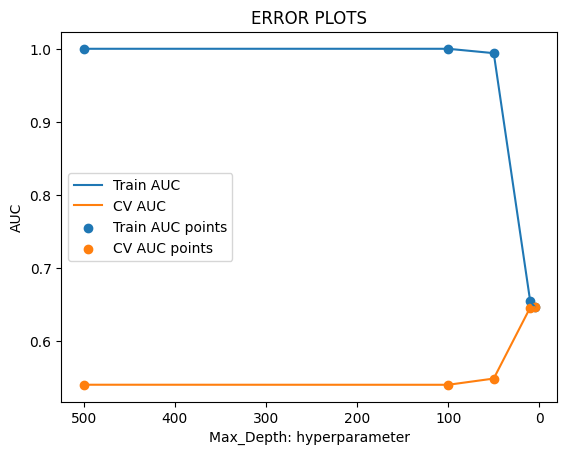

In [135]:
train_auc = []
test_auc = []
K = [5,10,50,100,500]

for i in tqdm(K):
    neigh = DecisionTreeClassifier(max_depth=i)
    neigh.fit(X_train_cn, y_train)
    y_train_pred = []
    for k in range(0,X_train_cn.shape[0],100):
        y_train_pred.extend(neigh.predict_proba(X_train_cn[k:k+100])[:,1])
    y_test_pred = []
    for k in range(0, X_test_cn.shape[0],500):
        y_test_pred.extend(neigh.predict_proba(X_test_cn[k:k+500])[:,1])
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    test_auc.append(roc_auc_score(y_test, y_test_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, test_auc, label='CV AUC')
plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, test_auc, label='CV AUC points')
plt.legend()
plt.xlabel("Max_Depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.gca().invert_xaxis()
plt.show()

#### 6.3.1 Train the Decision Tree Model using best parameters

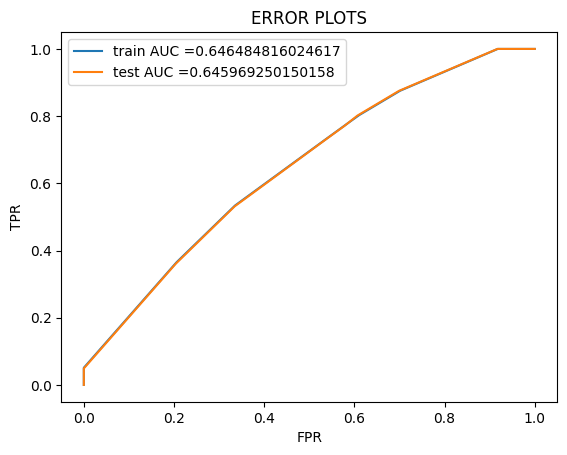

In [136]:
dt_best = DecisionTreeClassifier(max_depth=5).fit(X_train_cn, y_train)
y_train_pred = []
for k in range(0,X_train_cn.shape[0],100):
  y_train_pred.extend(dt_best.predict_proba(X_train_cn[k:k+100])[:,1])

y_test_pred = []
for k in range(0, X_test_cn.shape[0],100):
  y_test_pred.extend(dt_best.predict_proba(X_test_cn[k:k+100])[:,1])

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train,y_train_pred )
test_fpr, test_tpr, te_thresholds = roc_curve(y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

#### 6.3.2 Confusion matrix for Decision Trees

train Confusion Matrix
the maximum value of tpr*(1-fpr) 0.3549005966614803 for threshold 0.363
Number of misclassified points  37.51212724893574
-------------------- Confusion matrix --------------------


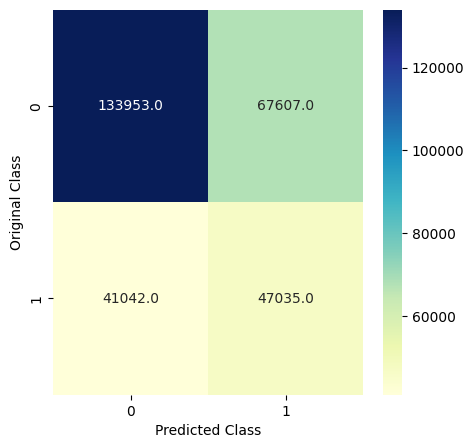

-------------------- Precision matrix (Columm Sum=1) --------------------


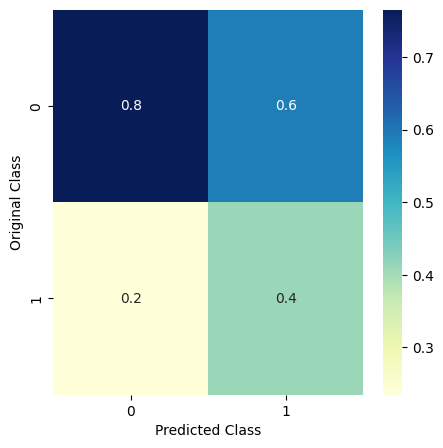

-------------------- Recall matrix (Row sum=1) --------------------


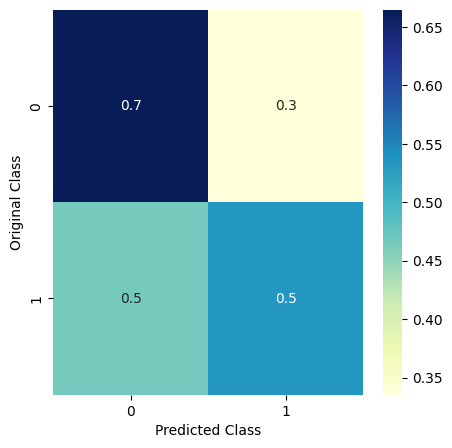

In [137]:
print("train Confusion Matrix")
plot_confusion_matrix(y_train,predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.35364398046369616 for threshold 0.363
Number of misclassified points  37.52487291651562
-------------------- Confusion matrix --------------------


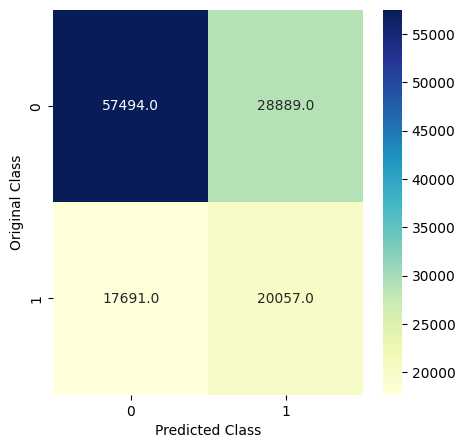

-------------------- Precision matrix (Columm Sum=1) --------------------


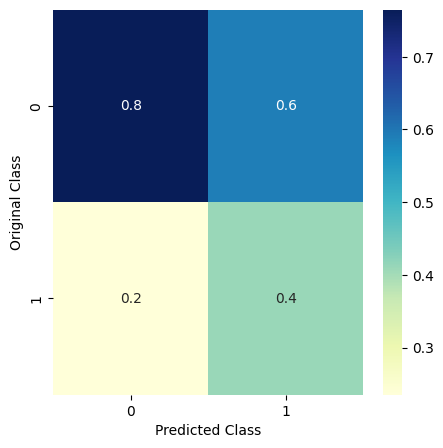

-------------------- Recall matrix (Row sum=1) --------------------


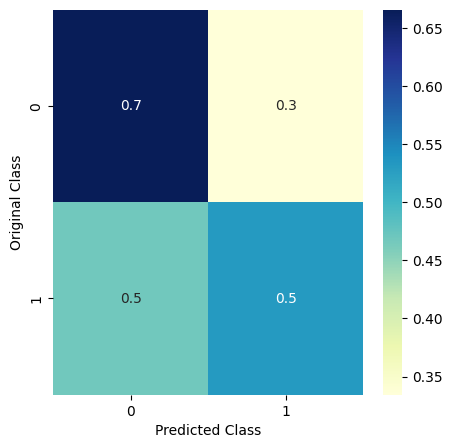

In [138]:
print("Test confusion matrix")
plot_confusion_matrix(y_test, predict( y_test_pred, te_thresholds, test_fpr, test_tpr))

#### 6.3.3 Visualize the Decision Trees using GraphViz

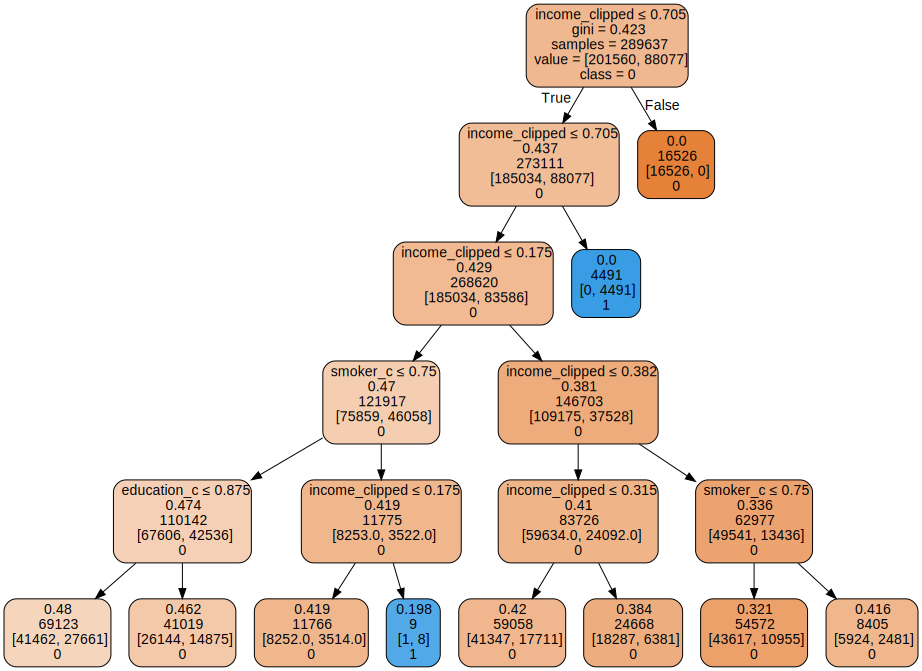

In [139]:
#https://stackoverflow.com/questions/39476020/get-feature-and-class-names-into-decision-tree-using-export-graphviz
dot_data = tree.export_graphviz(
    dt_best,
    max_depth =10,
    label='root',
    out_file=None,
    feature_names=column_names,
    class_names=['0','1'],
    filled=True,
    rounded=True,
    special_characters=True
    )
graph = graphviz.Source(dot_data)
graph

#### 6.3.4 Add Decision Trees Metrics to Metrics Table

In [140]:
metrics = list(calculate_metrics(y_test, y_test_pred))
metrics.insert(0,'Decision Trees')
metrics.insert(1,'test')
df_metrics.loc[len(df_metrics)] = metrics

metrics = list(calculate_metrics(y_train, y_train_pred))
metrics.insert(0,'Decision Trees')
metrics.insert(1,'train')
df_metrics.loc[len(df_metrics)] = metrics

#### 6.3.5 Feature Importance of Decision Trees

Feature: Number of Children, Score: 0.00000
Feature: income_clipped, Score: 0.96448
Feature: substance_c, Score: 0.00000
Feature: depression_c, Score: 0.00000
Feature: medical_c, Score: 0.00000
Feature: alcohol_c, Score: 0.00000
Feature: sleep_c, Score: 0.00000
Feature: dietary_c, Score: 0.00000
Feature: physical_c, Score: 0.00000
Feature: smoker_c, Score: 0.02844
Feature: marital_c, Score: 0.00000
Feature: education_c, Score: 0.00708
Feature: age_c, Score: 0.00000


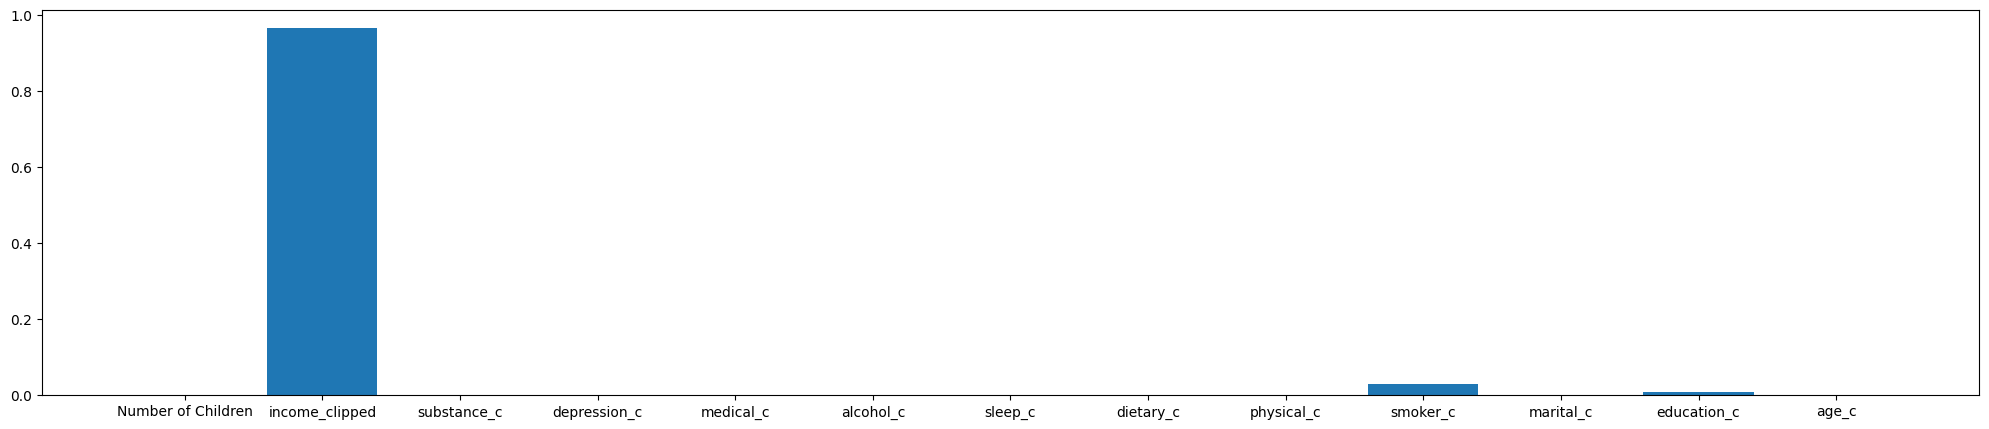

In [141]:
# Get importance
importance = dt_best.feature_importances_

# Summarize feature importance
for i, v in enumerate(importance):
    print(f'Feature: {feature_names[i]}, Score: {v:.5f}')

plt.figure(figsize=(25,5))
plt.bar([feature_names[x] for x in range(len(importance))], importance)
plt.show()

### 6.4 Train a Naive Bayes Model

In [75]:
min_max_scaler = preprocessing.MinMaxScaler().fit(X_train_cn.toarray())
X_train_cn = min_max_scaler.transform(X_train_cn.toarray())
X_test_cn = min_max_scaler.transform(X_test_cn.toarray())

100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


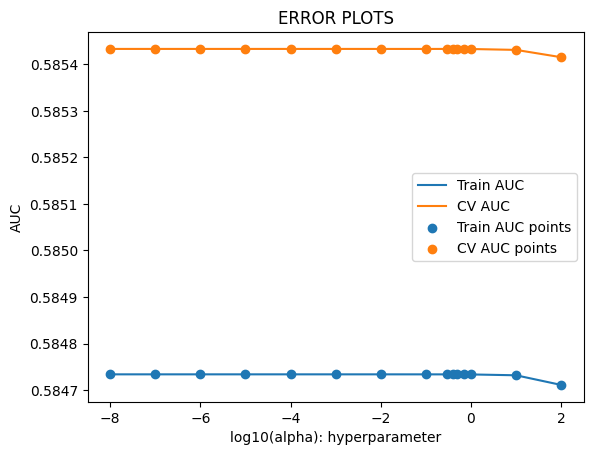

In [76]:
train_auc = []
test_auc = []

alpha_values = [10**-8,10**-7,10**-6,10**-5,10**-4,10**-3,10**-2,0.1,0.3,0.4,0.5,0.7,1,10,100]

for i in tqdm(alpha_values):
    Model_NB = MultinomialNB(alpha=i)
    Model_NB.fit(X_train_cn, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred = []
    for k in range(0,X_train_cn.shape[0],1000):
        y_train_pred.extend(Model_NB.predict_proba(X_train_cn[k:k+1000])[:,1])

    y_test_pred = []
    for k in range(0, X_test_cn.shape[0],500):
        y_test_pred.extend(Model_NB.predict_proba(X_test_cn[k:k+500])[:,1])

    train_auc.append(roc_auc_score(y_train,y_train_pred))
    test_auc.append(roc_auc_score(y_test, y_test_pred))

plt.plot(np.log10(alpha_values), train_auc, label='Train AUC')
plt.plot(np.log10(alpha_values), test_auc, label='CV AUC')
plt.scatter(np.log10(alpha_values), train_auc, label='Train AUC points')
plt.scatter(np.log10(alpha_values), test_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log10(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

## ***7. Limitations Of Model's***

In [142]:
y = PrettyTable()
y.add_column('limitation type',
             ["Ensemble", "Train Time","Test Time","Test Latency",
                 "feature Dependency","Probabilistic","Distance Metric","Feature Importance",
                 "Outlier Affect on Model","Categorical Features","Decision Boundary","Large Dimensions","balance Imablance Data"])

y.add_column("RandomForest",["yes", "Very High","High","Low","Yes","No","No","Very Good",'Moderate',"Very Good","Very Non Linear","Very Bad","No"])
y.add_column("Decision Tree",["no", "High","Moderate","Moderate","Yes","No","No","Good","High","Good","Non linear","Bad","Yes"])
y.add_column("Naive bayes",["No","Low", "Low","High","No","Yes","No","Good-very independent","Very Low","Good","Non Linear","Very Bad","Yes"])

print(y)

+-------------------------+-----------------+---------------+-----------------------+
|     limitation type     |   RandomForest  | Decision Tree |      Naive bayes      |
+-------------------------+-----------------+---------------+-----------------------+
|         Ensemble        |       yes       |       no      |           No          |
|        Train Time       |    Very High    |      High     |          Low          |
|        Test Time        |       High      |    Moderate   |          Low          |
|       Test Latency      |       Low       |    Moderate   |          High         |
|    feature Dependency   |       Yes       |      Yes      |           No          |
|      Probabilistic      |        No       |       No      |          Yes          |
|     Distance Metric     |        No       |       No      |           No          |
|    Feature Importance   |    Very Good    |      Good     | Good-very independent |
| Outlier Affect on Model |     Moderate    |      Hig

## ***8. Assesment  Of Model's***

In [143]:
print(tabulate(df_metrics, headers='keys', tablefmt='psql'))

+----+----------------+--------+------------+----------+-------------+----------+------------+---------------------+---------------------+
|    | model          | data   |   accuracy |      auc |   precision |   recall |   f1_score |   accuracy_positive |   accuracy_negative |
|----+----------------+--------+------------+----------+-------------+----------+------------+---------------------+---------------------|
|  0 | Random Forest  | test   |   0.601985 | 0.645507 |    0.395844 | 0.586866 |   0.472789 |            0.586866 |            0.608592 |
|  1 | Random Forest  | train  |   0.607999 | 0.669197 |    0.408263 | 0.643244 |   0.499497 |            0.643244 |            0.592598 |
|  2 | Decision Trees | test   |   0.624751 | 0.645969 |    0.409778 | 0.531339 |   0.462708 |            0.531339 |            0.665571 |
|  3 | Decision Trees | train  |   0.624879 | 0.646485 |    0.410277 | 0.534021 |   0.464041 |            0.534021 |            0.664581 |
+----+----------------+----

## ***9. Improve the Model***

<br> The Income and smoker feature are really important</br>
If we can find Sub Categories-  Feature Binning of Income, education and Smoker </br>For example - High income + Masters Deree + Smoker , Low income + High School + Non-Smoker </br>
Use Deep Learning Categorical vectors  for each category - which does provide more information about the Category </br>


<br> Oversampling the Data for the +ve Data </br>
We achieved a 65 AUC with basic hyperparametrization and Basic feature Engineering techniques, More additional Information would help the model </br>
Oversampling and collecting more data would definitely be hepful

## ***10. Excluding and Including features***

### 10.1 Excluding features

<hr> Section-1.3- Excluding 'name' feature </hr>
</br>We Removed the feature-- 'Name' in section-1.3 , As Names Cause Bias into our Models and are not a useful feature.

<hr> Section-1.5 - Excluding Constant Features </hr>
</br>We Removed the features where are features are constant in section-1.5 , These constant features do not provide any meaningful information and are not a useful feature</br>

<hr>Section-4.1.1 - Excluding Employement feature</hr>
</br> Employement feature is removed as they fail the Chi2-Test assuming feature Dependency in section-4.1.1 </br>
Employement feature is Corelated with Medicine and Depression Feature and Thus, we exclude Employement feature </br> Rather than excluding 'employement', we create new sub-categories 'employement + Medicine' and 'employement +depression'</br>

<hr>Section-4.2 - Excluding 'Age' and 'Income' feature </hr>
</br> Age is corelated with Age_categories and Income is corelated with Income_clipped</br>
The Visualizations in show how the feature's are corelated with Section-4.2 </br>

### 10.2  Including features

<hr>Section-2.1- Clipping the Income feature </hr>
</br>Clip the Income based on Box Plot's and IQR range in section-2.1 </br>
The Extreme Values in the Income feature Leads to presence of Outliers in the Model </br> The Income Above certain threshold are kept constant(equal to threshold) which decreases the affect of Income Outliers on the Model </br>

<hr> Section-2.3.2 - Including Age Category feature </hr>
</br>add a New Age Category feature in section-2.1 </br>
The Age is sub-categorized into teen, pre-teen, Adult, middle Age and Old </br> The Categories are Added as new feature into the Model hoping this additional information maybe helpful for the Model </br>

### 10.3 Narrative Supporting the Models

<br> As the Features in the model are al Categorical features, we cannot be using distance based metric Models like KNN, logistic regresion because with High Dimension's, the feature complexity is high and Distance measure can be a problem due to Curse of Dimensianlity</br> We dont tend to use Categorical features in One-hot encoding in the feature matrices and they make the matrices really sparse and have high Dimension</br> But we encode the categorical features into Ordinal features(categorical features which have order) and keep the Dimension of Matrices Small
</br>
Instead we use Trees based Methods like Decision trees and Random Forest and Probabilistic Methods Like Naive Bayes which are good with Ordinal Categorical features.